In [ ]:
!pip install GDAL
!pip install spectral
!pip install scikit-learn
!pip install scikit-image

In [ ]:
#importing required pakages 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import scipy
from osgeo import gdal
import matplotlib.pyplot as plt 
from spectral import*
from math import log10, sqrt
import cv2
import math
import scipy.misc
try:
    from skimage.restoration import denoise_tv_chambolle
except ImportError:
    # skimage < 0.12
    from skimage.filters import denoise_tv_chambolle

# Importing the Dataset and its Analysis 

In [ ]:
# reading dataset- Hyperspectral image  
dataset = gdal.Open('92AV3C.lan')
# reading dataset as array
dataset_ar = dataset.ReadAsArray()  
# dimentions of the hyperspectral image 
x = dataset.RasterXSize # x
y = dataset.RasterYSize # y
dim = dataset.RasterCount # Number of Bands
# spatial information
print("Value of x")
print(x)
print("--------------")
print("Value of y")
print(y)
print("--------------")
#spectral information
print("Band Size")
print(dim)

Value of x
145
--------------
Value of y
145
--------------
Band Size
220


Text(0.5, 1.0, 'Band-13')

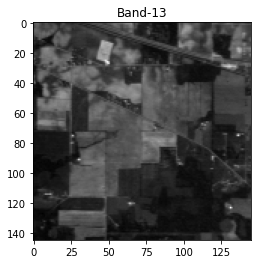

In [ ]:
# example of image in one of the band
ex=(dataset_ar[13])
plt.imshow(ex, cmap=plt.cm.gray)
plt.title("Band-13")

In [ ]:
RasterBands =[] # stores values in each band 
for i in range(dim+1):    
    RasterBands.append(dataset.GetRasterBand(i))  # get i band of the raster

####Statistical Analysis

In [ ]:
# mean values in each band
mean=[]
for i in range(1,len(RasterBands)) :
  m= RasterBands[i].ComputeBandStats()  
  mean.append(m[0])
sd=[]
#standard deviation in each band 
for i in range(1,len(RasterBands)) :
  m= RasterBands[i].ComputeBandStats()  
  sd.append(m[1])

<BarContainer object of 220 artists>

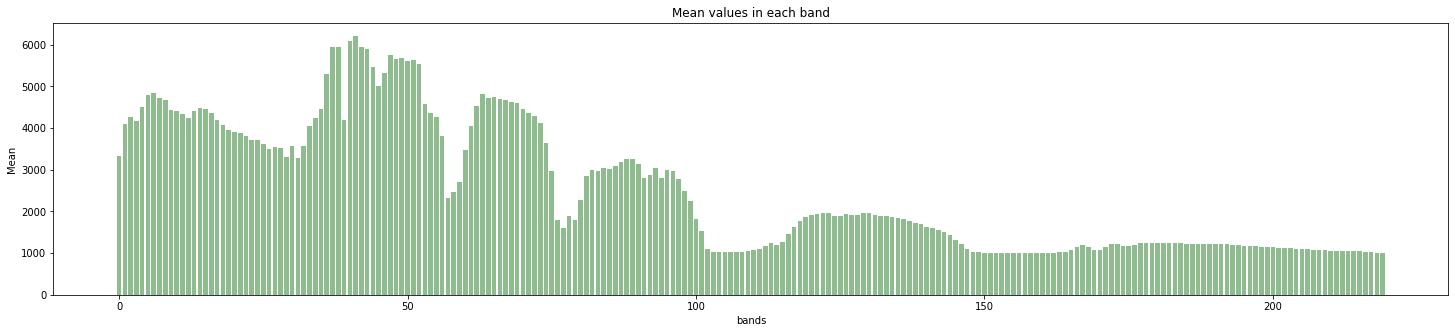

In [ ]:
# plot of mean and bands 
from matplotlib import pyplot as plt
plt.figure(figsize=(25,5))
plt.title("Mean values in each band")
plt.xlabel("bands")
plt.ylabel("Mean")
plt.bar(range(len(mean)),mean,color='darkseagreen')

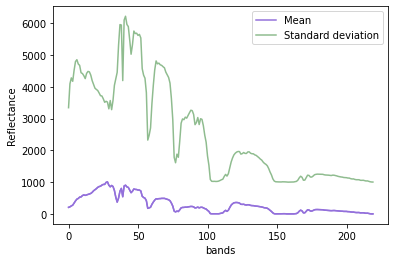

In [ ]:
plt.plot(range(len(sd)),sd,color='mediumpurple')
plt.plot(range(len(mean)),mean,color='darkseagreen')
plt.plot(range(len(sd)),sd,color='mediumpurple')
plt.xlabel("bands")
plt.ylabel("Reflectance")
plt.legend(["Mean", "Standard deviation"])

# Required Functions

Inter Band Blockwise Correlation 
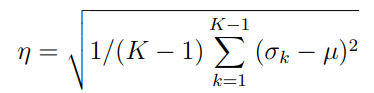

where k is the spectral band, K the total number of spectral
bands, σ the standard deviation of each band and μ the mean
of all standard deviation. The bands having standard deviation
larger than η will be considered as noisy.

In [ ]:
#Inter Band Blockwise Correlation
def inter_band_corr(dim,sd): # no. of bands and standard deviation are the parameter.
  c=0
  sd_arr=np.array(sd) # array od sd 
  for i in range(0,dim) :
    s=sd[i]
    c=c+math.pow((s-np.mean(sd)),2) # computing inter bandwise correlation using mentioned formula 
  corr=np.sqrt(1/(dim-1)*c)
  return corr # returning the correlation 

The term peak signal-to-noise ratio (PSNR) is an expression for the ratio between the maximum possible value (power) of a signal and the power of distorting noise that affects the quality of its representation.  Because many signals have a very wide dynamic range, (ratio between the largest and smallest possible values of a changeable quantity) the PSNR is usually expressed in terms of the logarithmic decibel scale.

MSE = mean((f-g).^2)

PSNR = 10*log_10((max(f)))/((MSE)^0.5)

---------------------------------------------------------------




*   f represents the matrix data of original image
*   g represents the matrix data of noise
*   maxf is the maximum signal value that exists in our original

















In [ ]:
#Peak Signal to noise Ratio
def PSNR(f, g):
    mse = np.mean((f - g) ** 2) # Mean Squared Error
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                   # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 10 * log10(max_pixel / sqrt(mse)) # psnr formula
    return psnr

In [ ]:
#Second Derivation Matrix
def dif2_matrix(x):
    '''
    In case for len(x) = 5:
    dif = np.array(
    [[-2, 1, 0, 0, 0],
     [1, -2, 1, 0, 0],
     [0, 1, -2, 1, 0],
     [0, 0, 1, -2, 1],
     [0, 0, 0, 1, -2]])
    '''
    # Diagoenal elements are -2.
    dif_now = np.diag(np.ones(len(x))) * -2
     
    # Left elements of diagonal are 1.
    dif_pre_ones = np.ones(len(x)-1) # 1 vector.
    dif_pre = np.diag(dif_pre_ones, k=-1) # Diagonal matrix shiftedto left.
 
    # Right elements of diagonal are 1.
    dif_post_ones = np.ones(len(x)-1) # 1 vector.
    dif_post = np.diag(dif_post_ones, k=1) # Diagonal matrix shiftedto right.
     
    dif  =  dif_now + dif_pre + dif_post
    return dif

Spatial Least Square Method: The least square denoising
for one-dimensional signal
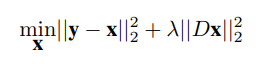


where ‘y’ is the one-dimensional input noisy signal, 

‘x’ is the actual resulting denoised signal 

 ‘D’ is the second derivative coefficient matrix
 
λ is the control parameter, which determines the weightage given to the terms

Solution to the minimization Problem is
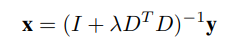


In [ ]:
# 1D Least square denoising 
def LS_1D(dif,y,lamda):  # has three parameter - second derivation matrix , y- noise , control parameter 
  n=len(y) # length of noise
  I=np.eye(n) # identity matrix of the len of noise 
  x=np.linalg.inv(I+lamda*(dif)@dif.T)@y # solution equation 
  return x 

Implementing 2D least square algorithm for denoising with the help od 1D LS denoising.
The denoising is first performed column wise and then
row wise.

In [ ]:
# 2D Least square denoising 
def LS_2D(dif,x,lamda):
  t=np.zeros(np.shape(x))
  t1=np.zeros(np.shape(x))
  for i in range(len(x)):
    temp=LS_1D(dif,x[i,:],lamda) # row wise denoising 
    t[i,:]=temp
  for i in range(len(t)):
    temp1=LS_1D(dif,t.T[i,:],lamda) # row wise denoising 
    t1[i,:]=temp1
  #output=LS_2D(dif,t.T,lamda) # column wise denoising 
  return t1
#y=(dataset_ar[28]) 
#t1=LS_2D(dif,y,0.1)
#output=LS_2D(dif,t.T,.1) # column wise denoising 

### Noisy Bands in the Given Hyperspectral Image

In [ ]:
# calculating threshold 
corr=inter_band_corr(dim,sd)
print("Threshold --> ",corr)

Threshold -->  273.3741641703108


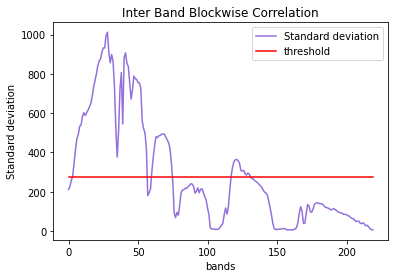

In [ ]:
# plotting 
corr_arr=corr*np.ones(dim, dtype = int) # single value to array 
plt.plot(range(len(sd)),sd,color='mediumpurple') # ploting sd
plt.plot(range(len(sd)),corr_arr,'r')# threshold 
# x,y,title,legend 
plt.xlabel("bands")
plt.ylabel("Standard deviation")
plt.title("Inter Band Blockwise Correlation")
plt.legend([ "Standard deviation","threshold"])

In [ ]:
 # values above the thresold is considered to be noise 
noise=[]
band_noise=[]
for i in range(0,len(sd)):
  # above threshold append the sd - threshold 
  if((sd[i]-corr)>0):
    noise.append(sd[i]-corr)
    band_noise.append(i)
  # below threshold append 0
  else:
     noise.append(0)

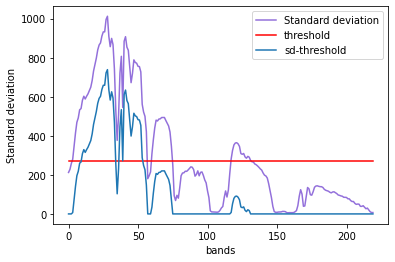

In [ ]:
plt.plot(range(len(sd)),sd,color='mediumpurple')
plt.plot(range(len(sd)),corr_arr,'r')
plt.plot(range(len(noise)),noise)
plt.xlabel("bands")
plt.ylabel("Standard deviation")
plt.legend([ "Standard deviation","threshold","sd-threshold"])

In [ ]:
print("bands with high noise :",band_noise)
print("Number of Noisy Band", len(band_noise))

bands with high noise : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
Number of Noisy Band 83


In [ ]:
temp=[]
for i in range(0,len(band_noise)):
  t=band_noise[i]
  temp.append(sd[t])
df = pd.DataFrame(list(zip(band_noise, temp)),
               columns =['Band Number', 'Standard Deviation'])
df.sort_values("Standard Deviation",ascending=False,ignore_index=True)
#df.iloc[41]

,Band Number,Standard Deviation
0,28,1012.162264
1,27,995.706229
2,26,932.192039
3,25,932.132141
4,24,910.675349
...,...,...
78,127,291.928491
79,130,290.441325
80,128,285.246017
81,117,280.773194


# Implementing the Least Square Method for Denoising 

In [ ]:
y=(dataset_ar[28]) /255
dif=dif2_matrix(y)
#x=np.zeros(np.shape(y))
x=[]
psnr=[]
for i in range(0,100):
  x.append(LS_2D(dif,y,i/100))
for i in range(len(x)):
  psnr.append(PSNR(y, x[i]))
#psnr


In [ ]:
y1=(dataset_ar[3]) /255
dif_1=dif2_matrix(y1)
#x=np.zeros(np.shape(y))
x1=[]
psnr1=[]
for i in range(0,100):
  x1.append(LS_2D(dif_1,y1,i/100))
for i in range(len(x1)):
  psnr1.append(PSNR(y1, x1[i]))
#psnr


In [ ]:
 y2=(dataset_ar[44]) /255
dif_2=dif2_matrix(y2)
#x=np.zeros(np.shape(y))
x2=[]
psnr2=[]
for i in range(0,100):
  x2.append(LS_2D(dif_2,y2,i/100))
for i in range(len(x2)):
  psnr2.append(PSNR(y2, x2[i]))
#psnr


# Plots of Lambda vs PSNR after Denoising Using Least Square Method

<Figure size 576x576 with 0 Axes>

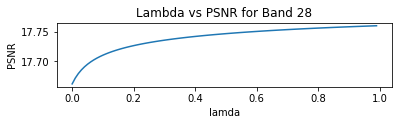

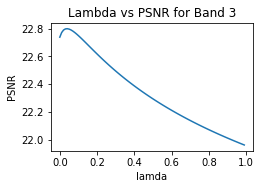

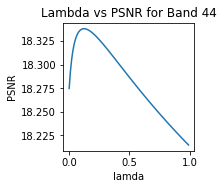

<Figure size 576x576 with 0 Axes>

In [ ]:
l=[]
for i in range(0,100):
  l.append(i/100)
plt.subplot(3,1,1),plt.plot(l,psnr)
plt.xlabel("lamda")
plt.ylabel("PSNR")
plt.title('Lambda vs PSNR for Band 28')
plt.figure(figsize=(8,8))
plt.subplot(3,2,1),plt.plot(l,psnr1);
plt.xlabel("lamda")
plt.ylabel("PSNR")
plt.title('Lambda vs PSNR for Band 3')
plt.figure(figsize=(8,8))
plt.subplot(3,3,1),plt.plot(l,psnr2)
plt.xlabel("lamda")
plt.ylabel("PSNR")
plt.title('Lambda vs PSNR for Band 44')
plt.figure(figsize=(8,8))

# Band Images (Original)

Text(0.5, 1.0, 'Band 44')

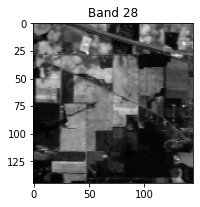

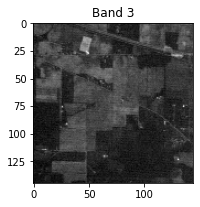

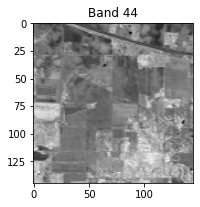

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1),plt.imshow(dataset_ar[28], cmap=plt.cm.gray);
plt.title('Band 28');
plt.figure(figsize=(10,10))
plt.subplot(3,1,2),plt.imshow(dataset_ar[3], cmap=plt.cm.gray);
plt.title('Band 3');
plt.figure(figsize=(10,10))
plt.subplot(3,1,3),plt.imshow(dataset_ar[44], cmap=plt.cm.gray)
plt.title('Band 44')


#Taking a Single Band and Analysing its Changes as we Vary Lambda

Text(0.5, 1.0, 'Band 28 with lamda 0.5')

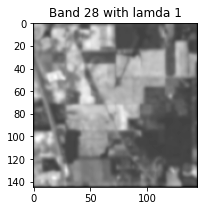

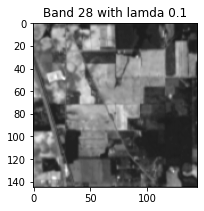

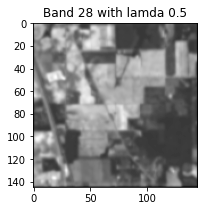

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1),plt.imshow(x[99], cmap=plt.cm.gray);
plt.title('Band 28 with lamda 1');
plt.figure(figsize=(10,10))
plt.subplot(1,3,2),plt.imshow(x[10], cmap=plt.cm.gray);
plt.title('Band 28 with lamda 0.1');
plt.figure(figsize=(10,10))
plt.subplot(1,3,3),plt.imshow(x[50], cmap=plt.cm.gray)
plt.title('Band 28 with lamda 0.5')


# Band Images after Denoising Using Least Square Method

Text(0.5, 1.0, 'Band 44')

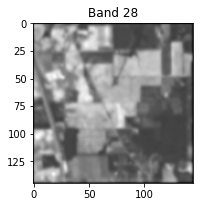

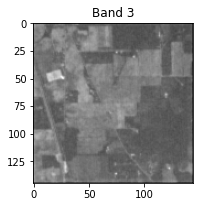

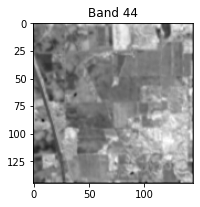

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1),plt.imshow(x[99], cmap=plt.cm.gray);
plt.title('Band 28');
plt.figure(figsize=(10,10))
plt.subplot(3,1,2),plt.imshow(x1[10], cmap=plt.cm.gray);
plt.title('Band 3');
plt.figure(figsize=(10,10))
plt.subplot(3,1,3),plt.imshow(x2[20], cmap=plt.cm.gray)
plt.title('Band 44')


# Total Variation Denoising Method

This is one another kind of denoising method that can be represented by the given formulation:

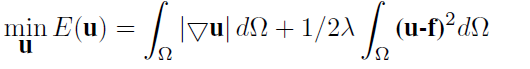
where 'f' is the noisy image, 'u' is the unknown denoised image, E is the minimization function of 'u' and 'λ' is the lagrange multiplier


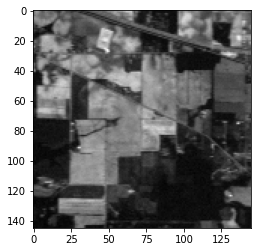

In [ ]:
x=(dataset_ar[28])/255
Noise=x
Noise= Noise+ 0.05 * x.std()*np.random.randn(*x.shape)
denoised_x = denoise_tv_chambolle(Noise, weight=0.1) 
plt.imshow(Noise, cmap=plt.cm.gray)

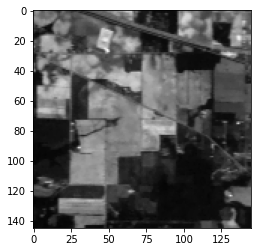

In [ ]:
plt.imshow(denoised_x, cmap=plt.cm.gray)

In [ ]:
PSNR(denoised_x,Noise)

32.925795834841196

Comparison of Band 28's PSNR vs Weights

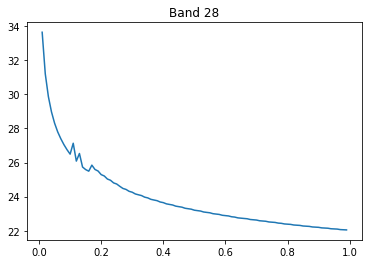

In [ ]:
yy=(dataset_ar[28]) /255
xx=[]
psnr_=[]
for i in range(1,100):
  xx.append(denoise_tv_chambolle(yy, weight=i/10))
for i in range(len(xx)):
  psnr_.append(PSNR(yy, xx[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
plt.title('Band 28')
plt.plot(l1,psnr_)

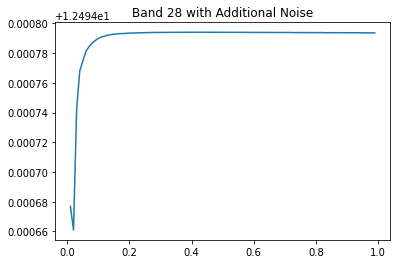

In [ ]:
yy_n=(dataset_ar[28]) /255
Noise=0
Noise= Noise+ 0.05 * yy_n.std()*np.random.randn(*yy_n.shape)
xx_n=[]
psnr_n=[]
for i in range(1,100):
  xx_n.append(denoise_tv_chambolle(Noise, weight=i/10))
for i in range(len(xx_n)):
  psnr_n.append(PSNR(yy_n, xx_n[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
  plt.title('Band 28 with Additional Noise')
plt.plot(l1,psnr_n)

Comparison of Band 3's PSNR vs Weights

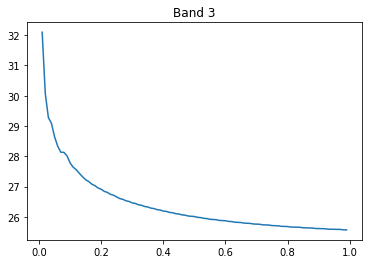

In [ ]:
yy2=(dataset_ar[3]) /255
xx2=[]
psnr_2=[]
for i in range(1,100):
  xx2.append(denoise_tv_chambolle(yy2, weight=i/10))
for i in range(len(xx)):
  psnr_2.append(PSNR(yy2, xx2[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
plt.title('Band 3')
plt.plot(l1,psnr_2)

Comparison of Band 44's PSNR vs Weights

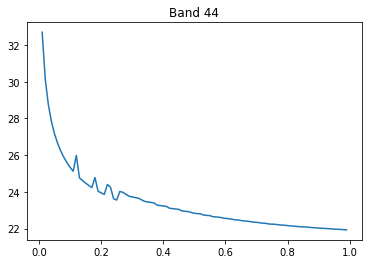

In [ ]:
yy3=(dataset_ar[44]) /255
xx3=[]
psnr_3=[]
for i in range(1,100):
  xx3.append(denoise_tv_chambolle(yy3, weight=i/10))
for i in range(len(xx)):
  psnr_3.append(PSNR(yy3, xx3[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
plt.title('Band 44')
plt.plot(l1,psnr_3)

Text(0, 0.5, 'PSNR')

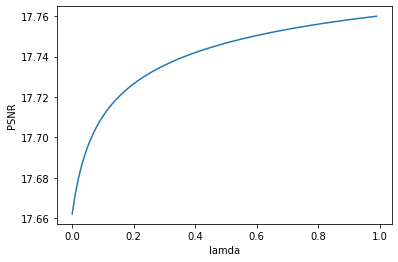

In [ ]:
plt.plot(l,psnr)
plt.xlabel("lamda")
plt.ylabel("PSNR")